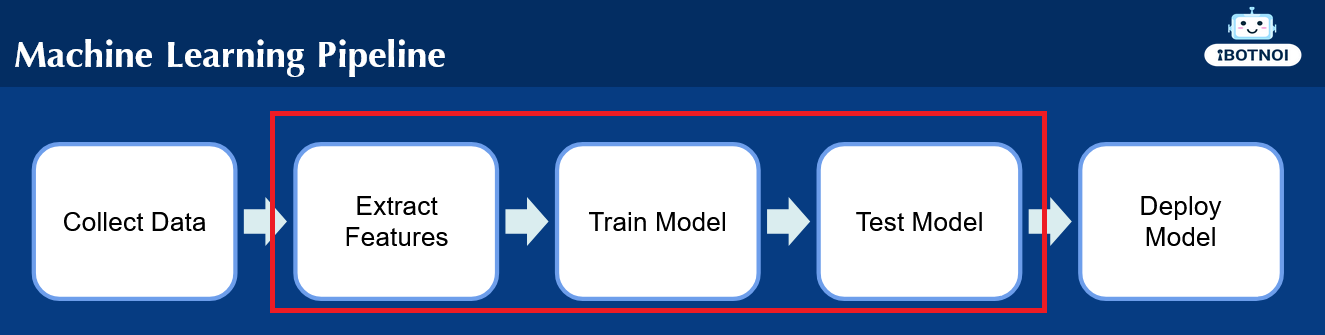

# All Pipeline
- [Import Library](#import_library)
- [Getting Data](#getting_data)
- [Classification Problem](#classification_problem)
  - [Cleaning Data](#cleaning_data_classification)
  - [Feature Extraction](#feature_extraction_classification)
    - [One-Hot Encoder vs Ordinal Encoder](#one_hot_encoder_vs_ordinal_encoder)
  - [Train / Test spliting data](#train_test_spliting_data_classification)
  - [Training Model](#training_model_classification)
    - [Logistic Regression](#logistic_regression_classification)
    - [Support Vector Machines](#support_vector_machines_classification)
    - [Decision Trees](#decision_trees_classification)
  - [Evaluate Model](#evaluate_model_classification)
- [Regression Problem](#regression_problem)
  - [Cleaning & Feature Extraction](#cleaning_and_feature_extraction)
  - [Train / Test spliting data](#train_test_spliting_data_regression)
  - [Training Model](#training_model_regression)
  - [Evaluate Model](#evaluate_model_regression)
  - [Prediction Pipeline](#prediction_pipeline_regression)

# Import Library <a name='import_library'></a>

https://scikit-learn.org/stable/

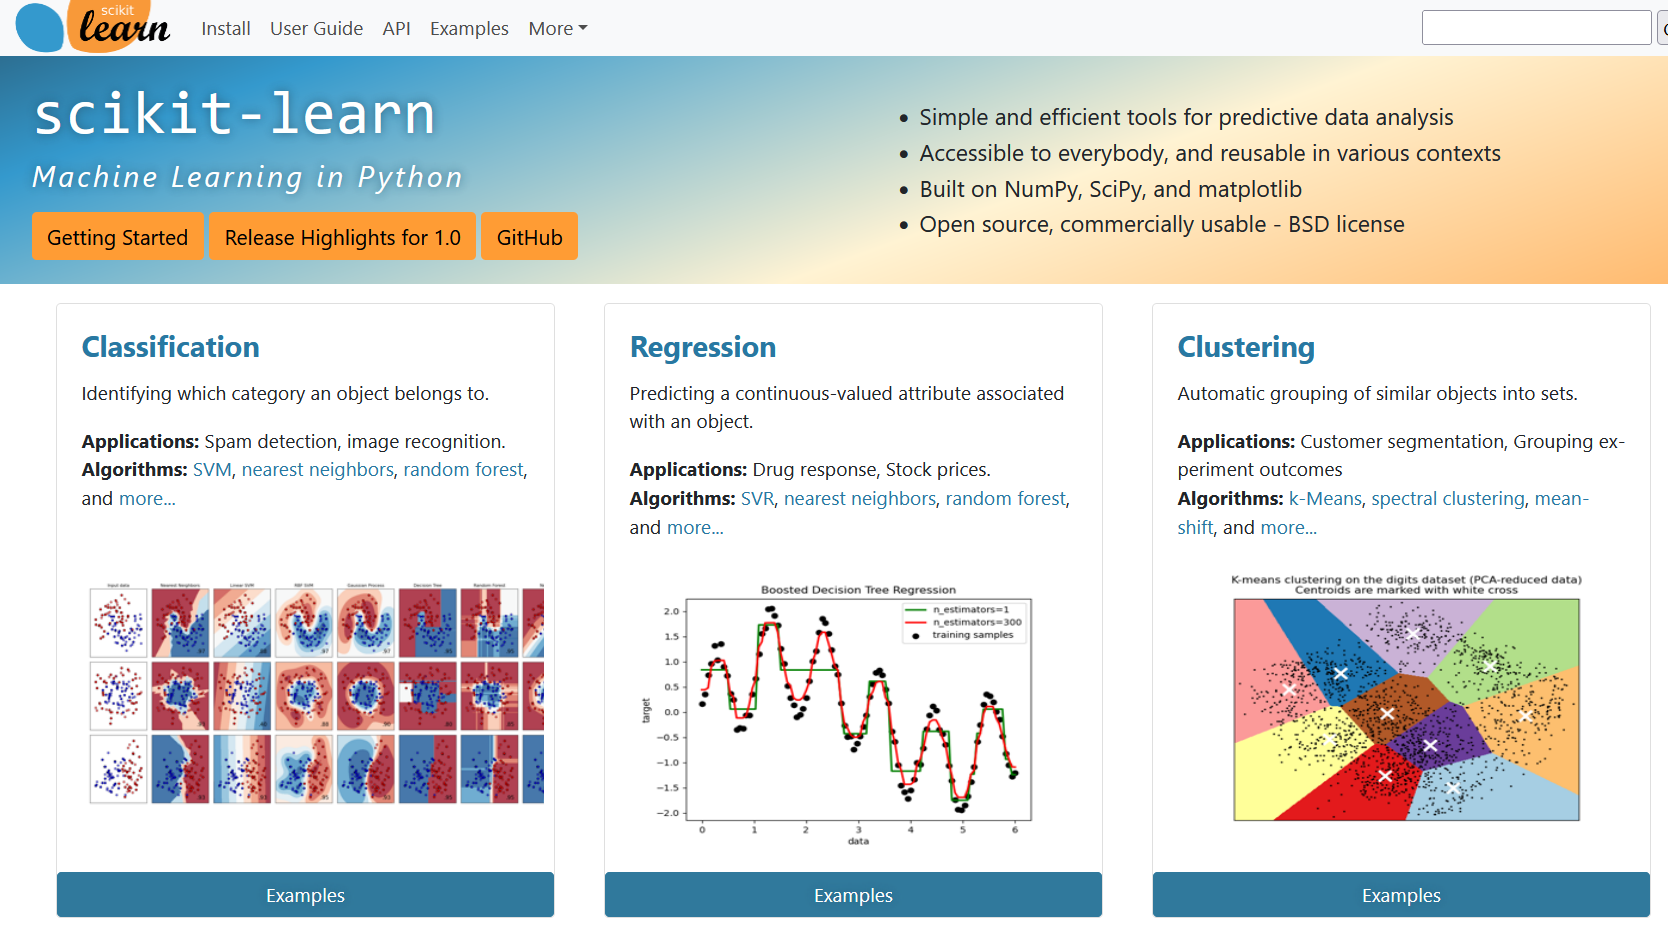

In [ ]:
!gdown --id 14pjXRN_Y3Fmf5VKzMgu_ewReD82J1OKP
!unzip TH-Sarabun-New.zip

Downloading...
From: https://drive.google.com/uc?id=14pjXRN_Y3Fmf5VKzMgu_ewReD82J1OKP
To: /content/TH-Sarabun-New.zip
100% 415k/415k [00:00<00:00, 3.21MB/s]
Archive:  TH-Sarabun-New.zip
  inflating: THSarabunNew Bold.ttf   
  inflating: THSarabunNew BoldItalic.ttf  
  inflating: THSarabunNew Italic.ttf  
  inflating: THSarabunNew.ttf        


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import pickle

In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunNew.ttf') 
mpl.rc('font', family='TH Sarabun New')

# Getting Data <a name='getting_data'></a>


In [ ]:
def getDataSheet(url, sheet):
  from google.colab import auth

  auth.authenticate_user()
  import gspread
  from oauth2client.client import GoogleCredentials
  gc = gspread.authorize(GoogleCredentials.get_application_default())

  wb = gc.open_by_url(url)
  sheet = wb.worksheet(sheet)
  data = sheet.get_all_values()
  return data

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1gGkmZqsLNntXpQSCMOdAhnsmjU4oBQCNlx6cpyaGZb4/edit?usp=sharing'
sheet = 'Responses'
data = getDataSheet(url, sheet)
data

[['Timestamp',
  'เพศ',
  'อายุ (กรุณากรอกเป็นตัวเลข)',
  'ปริมาณการใช้ Social media ต่อวัน (ชั่วโมง)',
  'Mobile OS',
  'มีแฟนหรือไม่',
  'น้ำหนัก(กรุณากรอกเป็นตัวเลข)',
  'ส่วนสูง(กรุณากรอกเป็นตัวเลข)'],
 ['18/08/2021 16:15:48', 'ชาย', '21', '6', 'iOS', 'ไม่มี', '64', '175'],
 ['18/08/2021 16:16:12', 'หญิง', '25', '3', 'iOS', 'มี', '45', '160'],
 ['18/08/2021 20:11:10', 'ชาย', '25', '3', 'iOS', 'มี', '72', '169'],
 ['18/08/2021 20:11:11', 'ชาย', '25', '5', 'iOS', 'มี', '60', '165'],
 ['18/08/2021 20:11:16', 'หญิง', '37', '3', 'iOS', 'มี', '58', '153'],
 ['18/08/2021 20:11:17', 'ชาย', '42', '2', 'Android', 'ไม่มี', '90', '178'],
 ['18/08/2021 20:11:20', 'ชาย', '23', '10', 'Android', 'มี', '68', '171'],
 ['18/08/2021 20:11:22', 'ชาย', '34', '>10', 'iOS', 'มี', '76', '165'],
 ['18/08/2021 20:11:22', 'หญิง', '33', '3', 'iOS', 'ไม่มี', '48', '155'],
 ['18/08/2021 20:11:23', 'ชาย', '31', '2', 'Android', 'มี', '65', '179'],
 ['18/08/2021 20:11:23', 'ชาย', '38', '8', 'Android', 'ไม่มี', '72'

In [ ]:
# แปลง List ของ Datasheet เป็น Dataframe
def list2DF(data):
  d = dict()
  columns = data[0]
  for c in columns:
    d[c] = []

  for i in range(len(data[1:])):
    for j in range(len(columns)):
      d[columns[j]].append(data[i+1][j])

  try:
    del d['Timestamp']
  except:
    pass
    
  df = pd.DataFrame(d)
  df.columns = ['sex', 'age', 'social time', 'mobile os', 'have girl/boyfriend', 'weight', 'height']
  
  return df

In [ ]:
df_raw = list2DF(data)
df_raw.head()

,sex,age,social time,mobile os,have girl/boyfriend,weight,height
0,ชาย,21,6,iOS,ไม่มี,64,175
1,หญิง,25,3,iOS,มี,45,160
2,ชาย,25,3,iOS,มี,72,169
3,ชาย,25,5,iOS,มี,60,165
4,หญิง,37,3,iOS,มี,58,153


# Classification Problem <a name='classification_problem'></a>

## Cleaning Data <a name='cleaning_data_classification'></a>

In [ ]:
# เลือกข้อมูล เฉพาะ column weight height sex และ row ที่มีข้อมูลเท่านั้น
dfwh = df_raw[(df_raw['weight'].str.len() != 0) & (df_raw['height'].str.len() != 0)]
dfwh = dfwh[['weight', 'height', 'sex']].reset_index(drop=True)

# เลือกเฉพาะข้อมูลที่เป็นตัวเลขใน column weight และ height
dfwh['weight'] = dfwh['weight'].apply(lambda x: re.findall(r'\d+', x)[0])
dfwh['height'] = dfwh['height'].apply(lambda x: re.findall(r'\d+', x)[0])

# ไม่ใช้ข้อมูลที่ไม่ระบุ
dfwh = dfwh[dfwh['sex'] != "ไม่ระบุ"]

# filter outlier
dfwh = dfwh[dfwh['height'].astype(int) < 300][dfwh['weight'].astype(int) < 300]
dfwh = dfwh[dfwh['height'].astype(int) > 100][dfwh['weight'].astype(int) > 20]

dfwh.head()

,weight,height,sex
0,64,175,ชาย
1,45,160,หญิง
2,72,169,ชาย
3,60,165,ชาย
4,58,153,หญิง


## Feature Extraction

In [ ]:
dfwh.loc[:5, 'sex']

0     ชาย
1    หญิง
2     ชาย
3     ชาย
4    หญิง
5     ชาย
Name: sex, dtype: object

In [ ]:
sex = dfwh['sex'].to_numpy()
sex = sex.reshape(sex.shape[0], 1)

sex

array([['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['หญิง'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['หญิง'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
 

### One-Hot Encoder VS. Ordinal Encoder

- One-Hot Encoder : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
- Ordinal Encoder : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

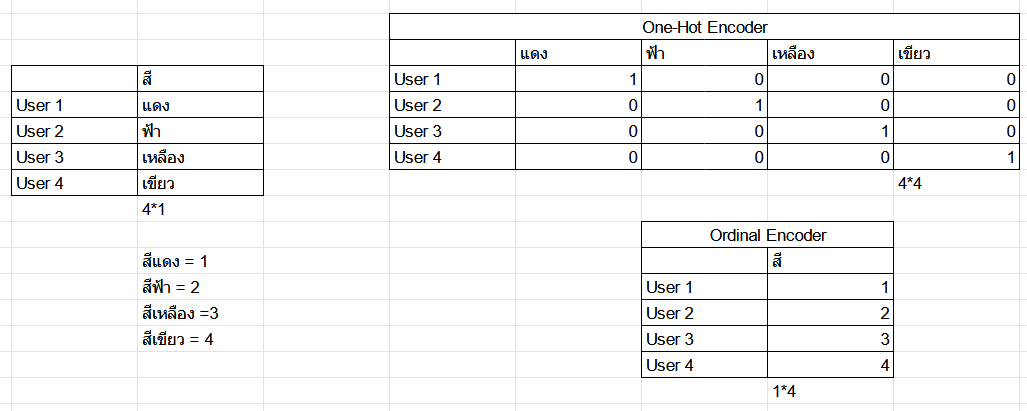

In [ ]:
100000 * 1000000

100000000000

In [ ]:
1 * 1000000

1000000

In [ ]:
from sklearn.preprocessing import OneHotEncoder

sex_en = OneHotEncoder()
new_sex = sex_en.fit_transform(sex)

new_sex.toarray()[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

sex_en = OrdinalEncoder()
new_sex = sex_en.fit_transform(sex)

new_sex[:5]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [ ]:
new_dfwh = dfwh.copy()

new_dfwh['sex'] = new_sex
new_dfwh.head()

,weight,height,sex
0,64,175,0.0
1,45,160,1.0
2,72,169,0.0
3,60,165,0.0
4,58,153,1.0


In [ ]:
dfwh.head()

,weight,height,sex
0,64,175,ชาย
1,45,160,หญิง
2,72,169,ชาย
3,60,165,ชาย
4,58,153,หญิง


## Train / Test spliting data <a name='train_test_spliting_data_classification'></a>

In [ ]:
# แยก feature กับ label
X = new_dfwh[['weight', 'height']]
y = new_dfwh['sex']

In [ ]:
from sklearn.model_selection import train_test_split
feat_train, feat_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train shape: ", feat_train.shape)
print("Test shape: ", feat_test.shape)

Train shape:  (63, 2)
Test shape:  (27, 2)


## Training Model <a name='training_model_classification'></a>

### Logistic Regression <a name='logistic_regression_classification'></a>

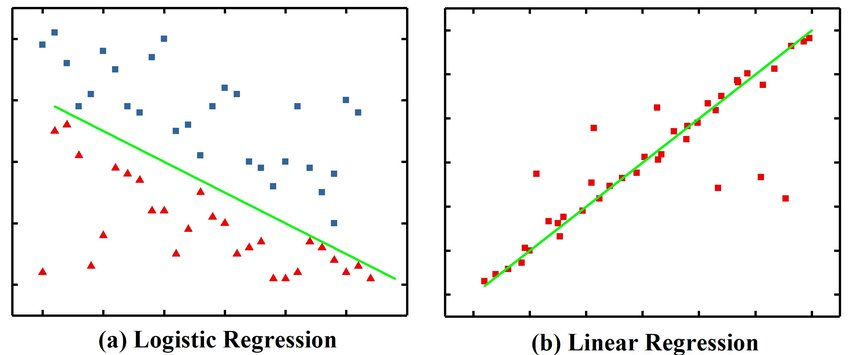

https://www.researchgate.net/figure/Logistic-regression-and-linear-regression_fig1_335786324

In [ ]:
from sklearn.linear_model import LogisticRegression

# train logistic regression model 
lor = LogisticRegression()
lor.fit(feat_train, label_train)

LogisticRegression()

### Support Vector Machines <a name='support_vector_machines_classification'></a>

https://scikit-learn.org/stable/modules/svm.html#classification

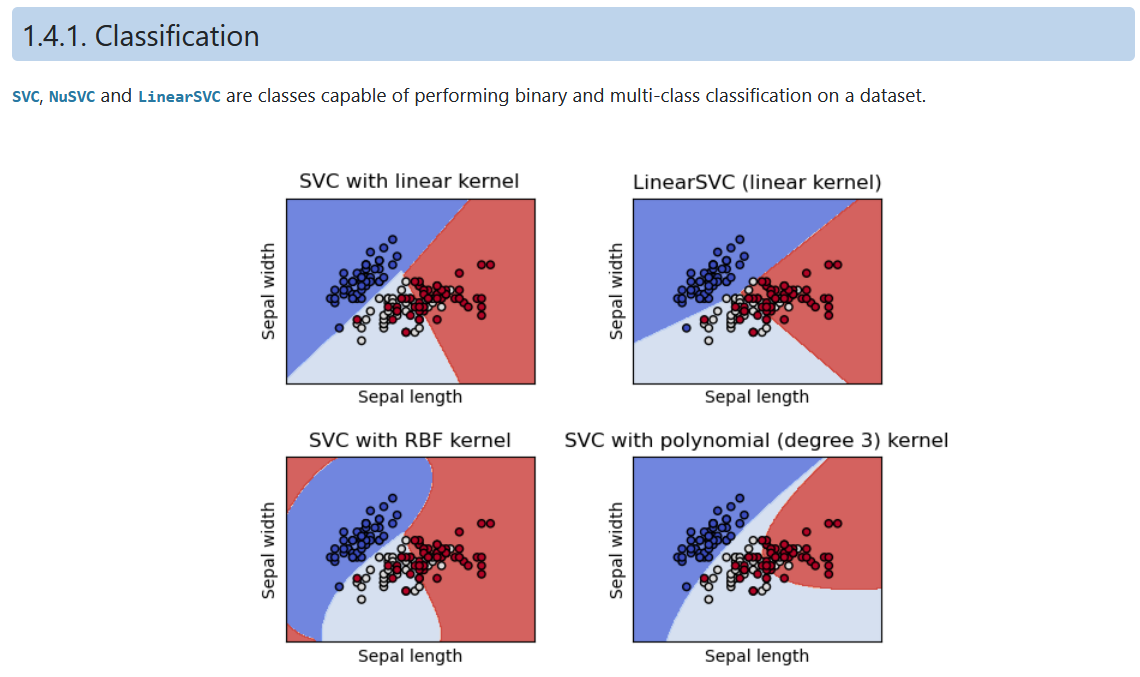

In [ ]:
from sklearn.svm import LinearSVC

# train Linear SVC model 
lsvc = LinearSVC()
lsvc.fit(feat_train, label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

### Decision Trees <a name='decision_trees_classification'></a>

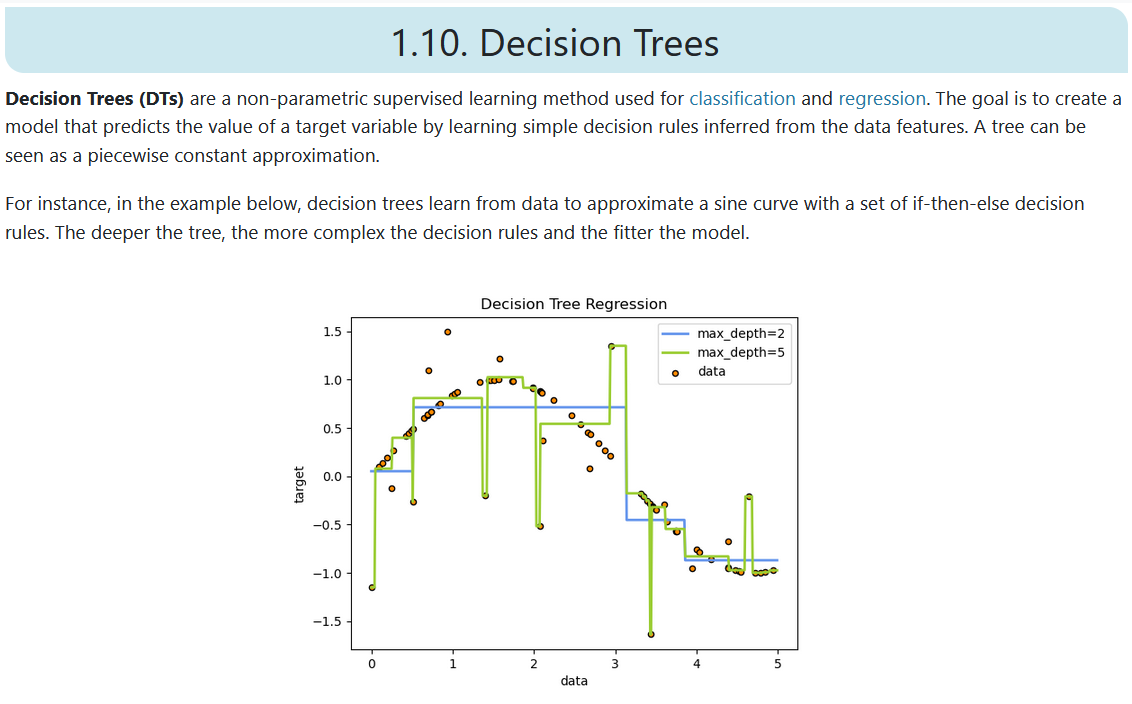

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# train Decision Tree model
clf = DecisionTreeClassifier()
clf.fit(feat_train, label_train)

DecisionTreeClassifier()

## Evaluate Model <a name='evaluate_model_classification'></a>

In [ ]:
from sklearn.metrics import accuracy_score

# ทดสอบ accuracy
pred = lor.predict(feat_test)
print("Logistic Regression Accuracy: ", accuracy_score(label_test, pred))

pred = lsvc.predict(feat_test)
print("Linear SVC Accuracy: ", accuracy_score(label_test, pred))

pred = clf.predict(feat_test)
print("DecisionTree Accuracy: ", accuracy_score(label_test, pred))

Logistic Regression Accuracy:  0.9259259259259259
Linear SVC Accuracy:  0.7407407407407407
DecisionTree Accuracy:  0.8888888888888888


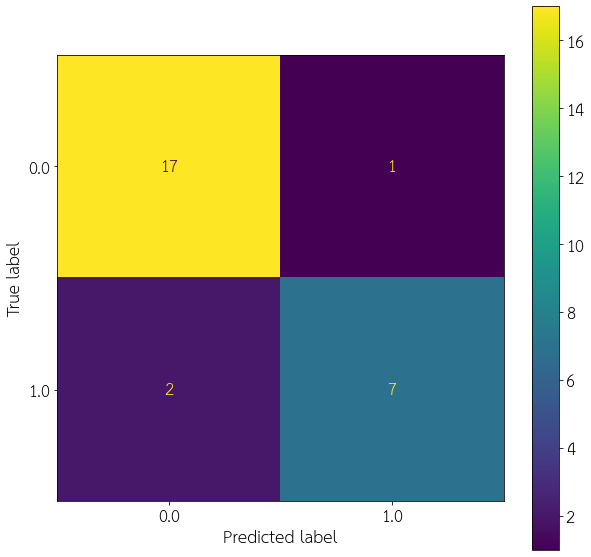

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(label_test, pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lor.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.rcParams.update({'font.size': 25})
plt.show()

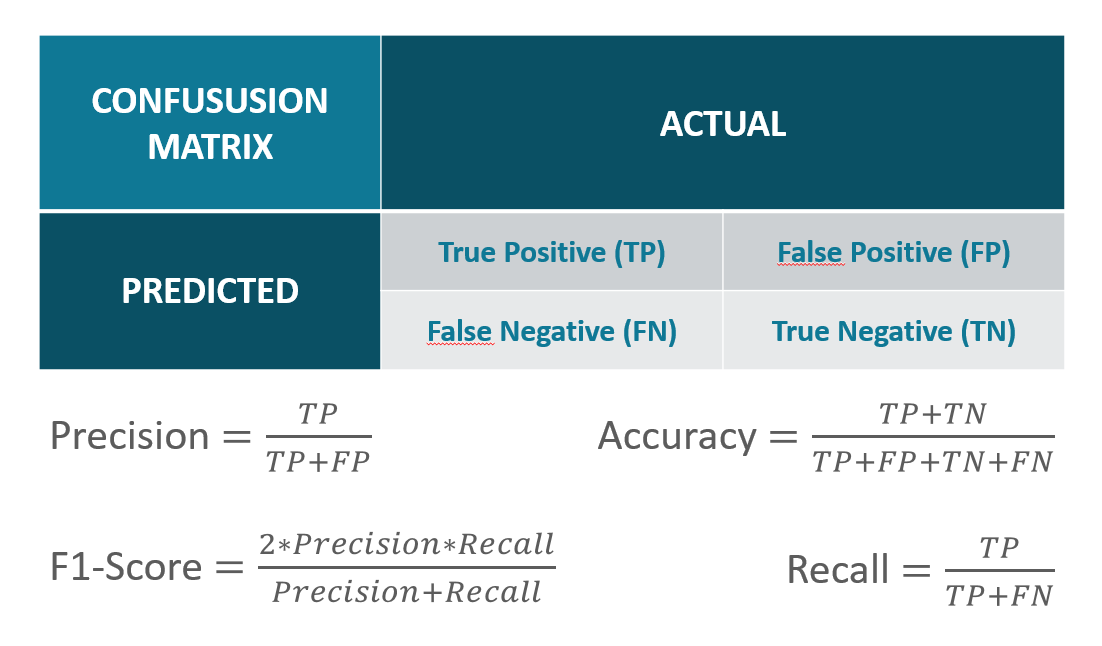

https://cubalytictalks.blogspot.com/2018/08/confusion-matrix.html

In [ ]:
new_label = label_test.to_numpy()
new_label = new_label.reshape([new_label.shape[0], 1])

new_pred = pred.reshape([pred.shape[0], 1])

new_label = sex_en.inverse_transform(new_label)
new_pred = sex_en.inverse_transform(new_pred)

In [ ]:
label_test

40    0.0
22    1.0
55    0.0
70    1.0
0     0.0
26    0.0
39    0.0
65    1.0
10    0.0
44    0.0
81    1.0
35    0.0
56    1.0
86    1.0
12    0.0
4     1.0
18    0.0
28    0.0
49    0.0
62    1.0
73    0.0
69    1.0
76    0.0
30    0.0
33    0.0
11    0.0
66    0.0
Name: sex, dtype: float64

In [ ]:
new_label

array([['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['หญิง'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย'],
       ['ชาย']], dtype=object)

In [ ]:
sex_en.categories_[0]

array(['ชาย', 'หญิง'], dtype=object)

In [ ]:
confusion_matrix(new_label, new_pred)

array([[17,  1],
       [ 2,  7]])

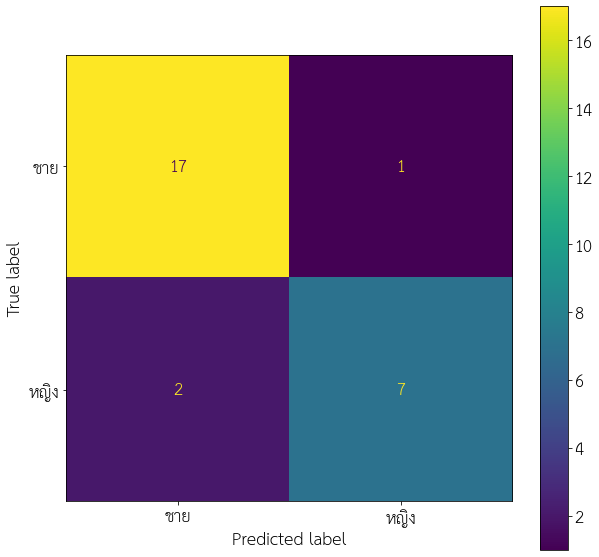

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(new_label, new_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sex_en.categories_[0])

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.rcParams.update({'font.size': 25})
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

b = lor.intercept_[0]
w1, w2 = lor.coef_.T
c = -b/w2
m = -w1/w2
xmin, xmax = dfwh['weight'].astype(int).min(), dfwh['weight'].astype(int).max()
ymin, ymax = dfwh['height'].astype(int).min(), dfwh['height'].astype(int).max()
xd = np.array([0, xmax+100])
ym = np.array([ymin, ymax])
yd = m*xd + c
yd[1] = 0
xdm = (yd-c)/m
xdp = [xd[0]+30, xd[1]-90]
ymp = [ym[0]-20, ym[1]+20]

fig = go.Figure()

fig.add_trace(go.Scatter(x=[0,xdm[1],0,0], y=[0,0,yd[0],0], fill="toself", 
                         fillcolor='pink', opacity=0.4,name="หญิง"))
fig.add_trace(go.Scatter(x=[xdm[1],0,xdm[1],xdm[1]], y=[yd[0],yd[0],0,yd[0]], 
                         fill="toself", fillcolor='green', opacity=0.2,name="ชาย"))
for valve, group in dfwh.groupby("sex"):
        fig.add_trace(go.Scatter(x=group["weight"], y=group["height"], name=valve, mode='markers',
                         marker=dict(
                                        size=5,
                                        color='blue'if valve == "ชาย" else 'red', #set color equal to a variable
                                    )))

fig.update_xaxes(range=xdp)
fig.update_yaxes(range=ymp)
fig.show();

In [ ]:
###@title gender predictor

weight =   58#@param {type:"number"}
height =  153#@param {type:"number"}
data = [[weight, height]]
pred = lor.predict(data)

print(pred)
pred = pred.reshape([pred.shape[0], 1])
gender = sex_en.inverse_transform(pred)

print("Gender: ",gender[0])


[1.]
Gender:  ['หญิง']


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



# Regression Problem (Social media time prediction) <a name='regression_problem'></a>

In [ ]:
df_raw.head()

,sex,age,social time,mobile os,have girl/boyfriend,weight,height
0,ชาย,21,6,iOS,ไม่มี,64,175
1,หญิง,25,3,iOS,มี,45,160
2,ชาย,25,3,iOS,มี,72,169
3,ชาย,25,5,iOS,มี,60,165
4,หญิง,37,3,iOS,มี,58,153


In [ ]:
df = df_raw[['sex', 'age', 'social time', 'mobile os', 'have girl/boyfriend']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sex                  90 non-null     object
 1   age                  90 non-null     object
 2   social time          90 non-null     object
 3   mobile os            90 non-null     object
 4   have girl/boyfriend  90 non-null     object
dtypes: object(5)
memory usage: 3.6+ KB


In [ ]:
df.head()

,sex,age,social time,mobile os,have girl/boyfriend
0,ชาย,21,6,iOS,ไม่มี
1,หญิง,25,3,iOS,มี
2,ชาย,25,3,iOS,มี
3,ชาย,25,5,iOS,มี
4,หญิง,37,3,iOS,มี


## Cleaning & Feature Extraction <a name='cleaning_and_feature_extraction'></a>

In [ ]:
# preprocessing และ ทำ onehot encoding
def preprocessLabel(Y):
  def prepY(y):
    if y == '>10':
      return 11.0
    if y == '<1':
      return 0.5
    else:
      return float(y)
  return Y.apply(prepY)

def preprocessData(X):
  from sklearn.preprocessing import OneHotEncoder
  enc = OneHotEncoder()
  x_data = X.copy()
  categories = ['sex', 'mobile os', 'have girl/boyfriend']
  encoded = enc.fit_transform(x_data[categories]).toarray()
  encoded = pd.DataFrame(encoded, columns = enc.get_feature_names(categories))
  x_data = pd.concat([x_data, encoded], axis=1)
  
  x_data = x_data.drop(categories, axis=1)
  x_data['age'] = x_data['age'].apply(lambda x: re.findall(r'\d+', x)[0])
  x_data = x_data.astype(float)
  x_data['age'] = x_data[x_data['age']>0][x_data['age']<99]
  return x_data, enc

X = df[['sex', 'age', 'mobile os', 'have girl/boyfriend']]
Y = df['social time']
X_preped, enpc = preprocessData(X)
Y_preped = preprocessLabel(Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
X_preped.head()

,age,sex_ชาย,sex_หญิง,mobile os_Android,mobile os_iOS,have girl/boyfriend_มี,have girl/boyfriend_ไม่มี
0,21.0,1.0,0.0,0.0,1.0,0.0,1.0
1,25.0,0.0,1.0,0.0,1.0,1.0,0.0
2,25.0,1.0,0.0,0.0,1.0,1.0,0.0
3,25.0,1.0,0.0,0.0,1.0,1.0,0.0
4,37.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
# ทำ normalization 
def norm(x_data):
  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler()
  X_norm = sc.fit_transform(x_data)
  return X_norm, sc

X_norm, sc = norm(X_preped)
X_norm[0]

array([0.06153846, 1.        , 0.        , 0.        , 1.        ,
       0.        , 1.        ])

##Train / Test spliting data <a name='train_test_spliting_data_regression'></a>

In [ ]:
# แยก feature กับ label
X_norm
Y_preped

0     6.0
1     3.0
2     3.0
3     5.0
4     3.0
     ... 
85    5.0
86    4.0
87    2.0
88    6.0
89    2.0
Name: social time, Length: 90, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
feat_train, feat_test, label_train, label_test = train_test_split(X_norm, Y_preped, test_size=0.3, random_state=42)
print("Train shape: ", feat_train.shape)
print("Test shape: ", feat_test.shape)

Train shape:  (63, 7)
Test shape:  (27, 7)


## Training Model <a name='training_model_regression'></a>

In [ ]:
from sklearn.linear_model import LinearRegression
  
lr = LinearRegression()
lr.fit(feat_train, label_train)

LinearRegression()

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
mlp.fit(feat_train, label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor()

In [ ]:
# train linear regression model
def train(X, Y):
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X, Y)
  return lr

lr = train(feat_train, label_train)
lr

LinearRegression()

## Evaluate Model <a name='evaluate_model_regression'></a>

In [ ]:
# ทดสอบประสิทธิภาพของ model ด้วยค่า RMSE
from sklearn.metrics import mean_squared_error

def evaluate(X, Y, model):
  pred = model.predict(X)
  return mean_squared_error(pred, Y)**0.5

In [ ]:
print("Linear Regression RMSE: ", round(evaluate(feat_test, label_test , lr), 2))
print("Multi Layer Perceptron RMSE: ", round(evaluate(feat_test, label_test , mlp), 2))

Linear Regression RMSE:  2.92
Multi Layer Perceptron RMSE:  3.14


In [ ]:
def train_pipeline(filename):
  # get data
  url = 'https://docs.google.com/spreadsheets/d/1gGkmZqsLNntXpQSCMOdAhnsmjU4oBQCNlx6cpyaGZb4/edit?usp=sharing'
  sheet = 'Responses'
  data = getDataSheet(url, sheet)
  df = list2DF(data)

  # extract features
  X, enc = preprocessData(df[['sex', 'age', 'mobile os', 'have girl/boyfriend']])
  X, sc = norm(X) 
  Y = preprocessLabel(df['social time'])

  # train / test split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

  # training
  lr = train(X_train, y_train)

  # save model
  pickle.dump(lr, open(filename+"_model.pickle", 'wb'))
  pickle.dump(sc, open(filename+"_scaler.pickle", 'wb'))
  pickle.dump(enc, open(filename+"_encoder.pickle", 'wb'))

  # evaluate
  print("RMSE :", round(evaluate(X_test, y_test, lr), 2))
  
  return lr, sc, enc

In [ ]:
train_pipeline(filename = "socialtime");

RMSE : 2.92


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## Prediction Pipeline <a name='prediction_pipeline_regression'></a>

In [ ]:
model = pickle.load(open("socialtime_model.pickle", 'rb'))
scaler = pickle.load(open("socialtime_scaler.pickle", 'rb'))
encoder = pickle.load(open("socialtime_encoder.pickle", 'rb'))

In [ ]:
def pred_pipeline(inp, model, sc, enc):
  columns = ['sex', 'age','mobile os','have girl/boyfriend']
  names = enc.get_feature_names([columns[0]] + columns[2:])
  s = pd.DataFrame({c:[inp[i]] for i, c in enumerate(columns)})
  encoded = enc.transform(s[[columns[0]] + columns[2:]])
  encoded = pd.DataFrame(encoded.toarray(), columns=names)
  x_data = pd.concat([s['age'], encoded], axis=1)
  inp_norm = sc.transform(x_data)
  pred = model.predict(inp_norm)
  return pred

array([[0.06153846, 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.        ],
       [0.12307692, 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.12307692, 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.12307692, 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.30769231, 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.38461538, 1.        , 0.        , 1.        , 0.        ,
        0.        , 1.        ],
       [0.09230769, 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        ],
       [0.26153846, 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.24615385, 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        ],
       [0.21538462, 1.        , 0.        , 1.        , 0.        ,
        1.        , 0. 

In [ ]:
print(df.iloc[0].values)
pred_pipeline(X.iloc[0].values, model, scaler, encoder)

['ชาย' '21' '6' 'iOS' 'ไม่มี']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



array([6.15891343])

In [ ]:
###@title Social media time estimator

Gender =  '\u0E0A\u0E32\u0E22' #@param ['ชาย', 'หญิง', 'ไม่ระบุ']{type:"string"}
Age =  20 #@param {type:"number"}
MobileOS = 'iOS' #@param ['Android', 'iOS', 'Windows OS', 'Blackberry OS'] {type:"string"}
Having_GirlorBoyfriend = '\u0E21\u0E35' #@param ['มี', 'ไม่มี']{type:"string"}
answer_list = np.array([Gender, Age, MobileOS, Having_GirlorBoyfriend])


print("Social media time: ", round(pred_pipeline(answer_list, lr, sc, encoder)[0], 2), "hours")


Social media time:  6.52 hours


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

